In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
from nltk import word_tokenize

In [4]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_valid = pd.read_csv("data/valid.csv")

In [5]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

train_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
test_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
valid_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

train_tokenizer.fit_on_texts(df_train["clean_text"].values)
train_word_index = train_tokenizer.word_index
print(f"Found {len(train_word_index)} unique tokens.")

test_tokenizer.fit_on_texts(df_test["clean_text"].values)
test_word_index = test_tokenizer.word_index
print(f"Found {len(test_word_index)} unique tokens.")

valid_tokenizer.fit_on_texts(df_valid["clean_text"].values)
valid_word_index = valid_tokenizer.word_index
print(f"Found {len(valid_word_index)} unique tokens.")

Found 7923 unique tokens.
Found 4963 unique tokens.
Found 1905 unique tokens.


In [6]:
X_train = train_tokenizer.texts_to_sequences(df_train["clean_text"].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)

Y_train = pd.get_dummies(df_train["label"]).values
print('Shape of label tensor:', Y_train.shape)

Shape of data tensor: (3257, 250)
Shape of label tensor: (3257, 4)


In [7]:
X_test = train_tokenizer.texts_to_sequences(df_test["clean_text"].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Y_test = pd.get_dummies(df_test["label"]).values
print('Shape of label tensor:', Y_test.shape)

Shape of data tensor: (1420, 250)
Shape of label tensor: (1420, 4)


In [8]:
X_valid = train_tokenizer.texts_to_sequences(df_valid["clean_text"].values)
X_valid = pad_sequences(X_valid, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_valid.shape)

Y_valid = pd.get_dummies(df_valid["label"]).values
print('Shape of label tensor:', Y_valid.shape)

Shape of data tensor: (374, 250)
Shape of label tensor: (374, 4)


In [9]:
len(X_train)+len(X_test)+len(X_valid)

5051

In [10]:
def make_model(units, dropout, recurrent_dropout):
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(4, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    print(model.summary())
    
    return model

In [11]:
model_1 = make_model(10, 0.2, 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 10)                4440      
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 5,004,484
Trainable params: 5,004,484
Non-trainable params: 0
_________________________________________________________________
None


2022-02-05 15:37:58.492850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 15:37:58.508354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-02-05 15:37:58.512049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-02-05 15:37:58.512063: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required

In [12]:
epochs = 10
batch_size = 64

history = model_1.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)]
                   )

Epoch 1/10
51/51 [==============================] - 11s 184ms/step - loss: 1.3120 - accuracy: 0.4283 - val_loss: 1.2576 - val_accuracy: 0.4278
Epoch 2/10
51/51 [==============================] - 10s 191ms/step - loss: 1.1466 - accuracy: 0.4630 - val_loss: 1.1263 - val_accuracy: 0.4893
Epoch 3/10
51/51 [==============================] - 9s 185ms/step - loss: 0.8558 - accuracy: 0.7095 - val_loss: 1.0231 - val_accuracy: 0.5802
Epoch 4/10
51/51 [==============================] - 10s 191ms/step - loss: 0.5676 - accuracy: 0.8391 - val_loss: 0.9227 - val_accuracy: 0.6417
Epoch 5/10
51/51 [==============================] - 10s 191ms/step - loss: 0.4004 - accuracy: 0.8806 - val_loss: 0.9176 - val_accuracy: 0.6364
Epoch 6/10
51/51 [==============================] - 10s 203ms/step - loss: 0.3057 - accuracy: 0.9067 - val_loss: 0.9368 - val_accuracy: 0.6337
Epoch 7/10
51/51 [==============================] - 10s 200ms/step - loss: 0.2381 - accuracy: 0.9386 - val_loss: 0.9714 - val_accuracy: 0.6364


In [13]:
accr = model_1.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

45/45 [==============================] - 1s 18ms/step - loss: 0.9642 - accuracy: 0.6585
Test set
  Loss: 0.964
  Accuracy: 0.658


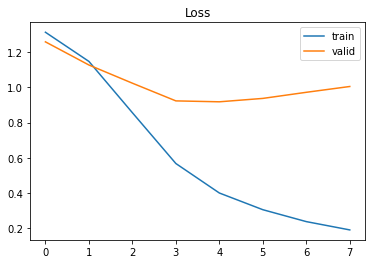

In [14]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

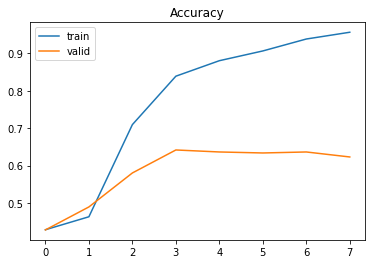

In [15]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();

              precision    recall  f1-score   support

           0       0.70      0.80      0.75       558
           1       0.69      0.58      0.63       357
           2       0.63      0.10      0.17       123
           3       0.58      0.71      0.64       382

    accuracy                           0.66      1420
   macro avg       0.65      0.55      0.55      1420
weighted avg       0.66      0.66      0.64      1420



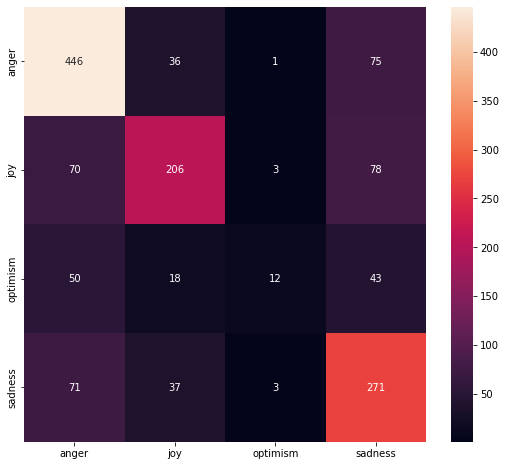

In [16]:
y_pred = np.argmax(model_1.predict(X_test), axis=-1)
y_true = list(df_test["label"])

print(classification_report(y_true, y_pred))

fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
            xticklabels=["anger", "joy", "optimism", "sadness"],
            yticklabels=["anger", "joy", "optimism", "sadness"], 
            ax=ax)
plt.show()

In [17]:
model_2 = make_model(50, 0.2, 0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                                 
Total params: 5,030,404
Trainable params: 5,030,404
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
epochs = 10
batch_size = 64

history = model_2.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)]
                   )

Epoch 1/10
51/51 [==============================] - 13s 223ms/step - loss: 1.2789 - accuracy: 0.4209 - val_loss: 1.2376 - val_accuracy: 0.4278
Epoch 2/10
51/51 [==============================] - 12s 237ms/step - loss: 1.1243 - accuracy: 0.4989 - val_loss: 1.0554 - val_accuracy: 0.5455
Epoch 3/10
51/51 [==============================] - 12s 226ms/step - loss: 0.6469 - accuracy: 0.7891 - val_loss: 0.9587 - val_accuracy: 0.5936
Epoch 4/10
51/51 [==============================] - 11s 222ms/step - loss: 0.3210 - accuracy: 0.8984 - val_loss: 0.9620 - val_accuracy: 0.6497
Epoch 5/10
51/51 [==============================] - 11s 218ms/step - loss: 0.1682 - accuracy: 0.9561 - val_loss: 1.1122 - val_accuracy: 0.6390
Epoch 6/10
51/51 [==============================] - 11s 219ms/step - loss: 0.1022 - accuracy: 0.9714 - val_loss: 1.1180 - val_accuracy: 0.6230


In [19]:
accr = model_2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

45/45 [==============================] - 1s 20ms/step - loss: 1.0308 - accuracy: 0.6542
Test set
  Loss: 1.031
  Accuracy: 0.654


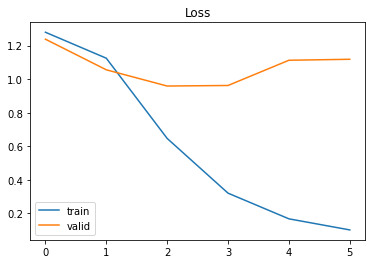

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

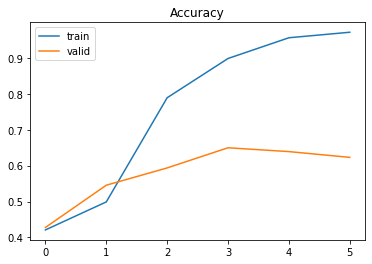

In [21]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       558
           1       0.71      0.55      0.62       357
           2       0.47      0.28      0.35       123
           3       0.56      0.72      0.63       382

    accuracy                           0.65      1420
   macro avg       0.62      0.58      0.59      1420
weighted avg       0.66      0.65      0.65      1420



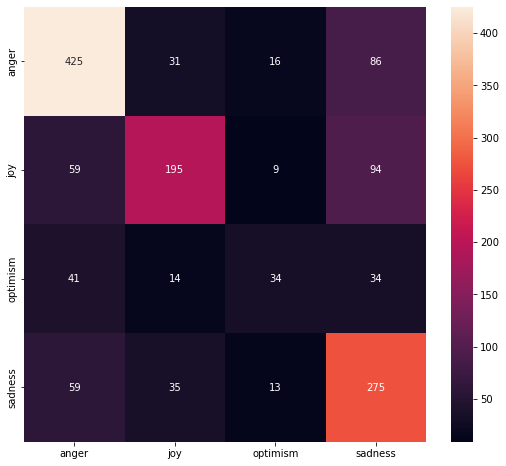

In [22]:
y_pred = np.argmax(model_2.predict(X_test), axis=-1)
y_true = list(df_test["label"])

print(classification_report(y_true, y_pred))

fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
            xticklabels=["anger", "joy", "optimism", "sadness"],
            yticklabels=["anger", "joy", "optimism", "sadness"], 
            ax=ax)
plt.show()

In [23]:
model_3 = make_model(100, 0.2, 0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
epochs = 10
batch_size = 64

history = model_3.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)]
                   )

Epoch 1/10
51/51 [==============================] - 15s 274ms/step - loss: 1.2714 - accuracy: 0.4246 - val_loss: 1.2324 - val_accuracy: 0.4278
Epoch 2/10
51/51 [==============================] - 15s 295ms/step - loss: 1.0599 - accuracy: 0.5591 - val_loss: 1.0024 - val_accuracy: 0.5775
Epoch 3/10
51/51 [==============================] - 15s 296ms/step - loss: 0.5460 - accuracy: 0.8146 - val_loss: 0.9574 - val_accuracy: 0.6123
Epoch 4/10
51/51 [==============================] - 17s 337ms/step - loss: 0.2646 - accuracy: 0.9171 - val_loss: 1.0061 - val_accuracy: 0.6043
Epoch 5/10
51/51 [==============================] - 16s 312ms/step - loss: 0.1309 - accuracy: 0.9589 - val_loss: 1.1203 - val_accuracy: 0.6230
Epoch 6/10
51/51 [==============================] - 13s 265ms/step - loss: 0.0821 - accuracy: 0.9751 - val_loss: 1.2061 - val_accuracy: 0.6043


In [25]:
accr = model_3.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

45/45 [==============================] - 1s 32ms/step - loss: 1.1125 - accuracy: 0.6486
Test set
  Loss: 1.113
  Accuracy: 0.649


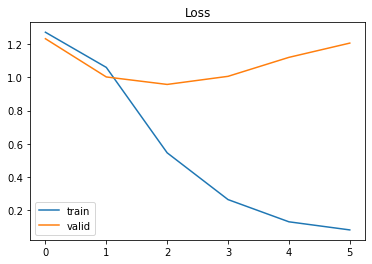

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

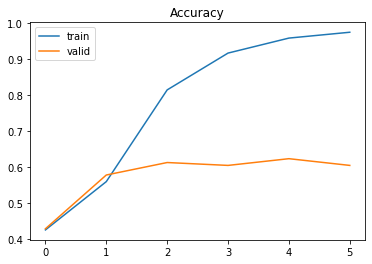

In [27]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       558
           1       0.68      0.59      0.63       357
           2       0.36      0.40      0.38       123
           3       0.61      0.64      0.63       382

    accuracy                           0.65      1420
   macro avg       0.59      0.59      0.59      1420
weighted avg       0.65      0.65      0.65      1420



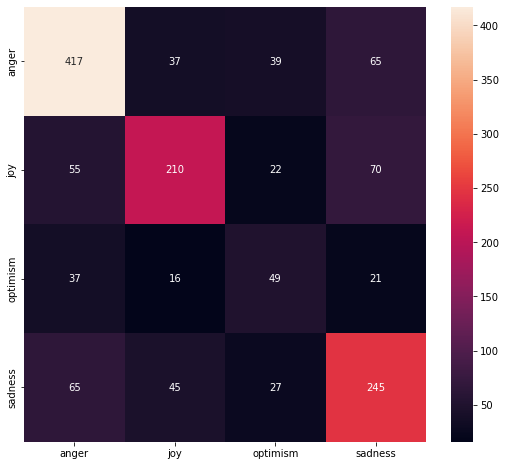

In [28]:
y_pred = np.argmax(model_3.predict(X_test), axis=-1)
y_true = list(df_test["label"])

print(classification_report(y_true, y_pred))

fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
            xticklabels=["anger", "joy", "optimism", "sadness"],
            yticklabels=["anger", "joy", "optimism", "sadness"], 
            ax=ax)
plt.show()

In [29]:
model_4 = make_model(200, 0.2, 0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 200)               240800    
                                                                 
 dense_3 (Dense)             (None, 4)                 804       
                                                                 
Total params: 5,241,604
Trainable params: 5,241,604
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
epochs = 10
batch_size = 64

history = model_4.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)]
                   )

Epoch 1/10
51/51 [==============================] - 37s 697ms/step - loss: 1.2668 - accuracy: 0.4234 - val_loss: 1.2236 - val_accuracy: 0.4278
Epoch 2/10
51/51 [==============================] - 35s 685ms/step - loss: 1.0042 - accuracy: 0.5959 - val_loss: 0.9682 - val_accuracy: 0.6257
Epoch 3/10
51/51 [==============================] - 37s 717ms/step - loss: 0.4765 - accuracy: 0.8382 - val_loss: 0.9801 - val_accuracy: 0.6203
Epoch 4/10
51/51 [==============================] - 42s 822ms/step - loss: 0.2513 - accuracy: 0.9294 - val_loss: 1.1035 - val_accuracy: 0.6150
Epoch 5/10
51/51 [==============================] - 37s 737ms/step - loss: 0.1189 - accuracy: 0.9641 - val_loss: 1.2348 - val_accuracy: 0.5963


In [31]:
accr = model_4.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

45/45 [==============================] - 3s 74ms/step - loss: 1.0919 - accuracy: 0.6535
Test set
  Loss: 1.092
  Accuracy: 0.654


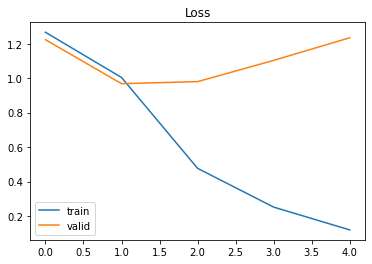

In [32]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

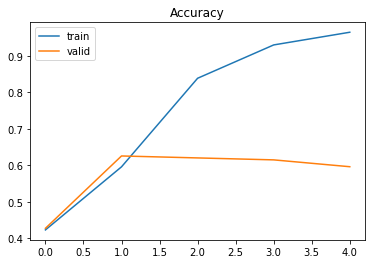

In [33]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       558
           1       0.68      0.57      0.62       357
           2       0.46      0.29      0.36       123
           3       0.57      0.71      0.63       382

    accuracy                           0.65      1420
   macro avg       0.61      0.58      0.59      1420
weighted avg       0.65      0.65      0.65      1420



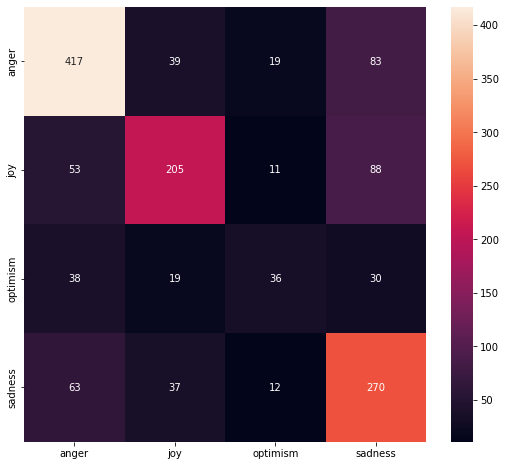

In [34]:
y_pred = np.argmax(model_4.predict(X_test), axis=-1)
y_true = list(df_test["label"])

print(classification_report(y_true, y_pred))

fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
            xticklabels=["anger", "joy", "optimism", "sadness"],
            yticklabels=["anger", "joy", "optimism", "sadness"], 
            ax=ax)
plt.show()

In [35]:
model_5 = Sequential()
model_5.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model_5.add(SpatialDropout1D(0.2))
model_5.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_5.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_5.add(Dense(4, activation="softmax"))
model_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model_5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 250, 100)          80400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 4)                 404       
                                                                 
Total params: 5,161,204
Trainable params: 5,161,204
Non-trainable params: 0
____________________________________________

In [36]:
epochs = 10
batch_size = 64

history = model_5.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[EarlyStopping(monitor="val_loss", patience=3, min_delta=0.0001)]
                   )

Epoch 1/10
51/51 [==============================] - 28s 499ms/step - loss: 1.2733 - accuracy: 0.4274 - val_loss: 1.2541 - val_accuracy: 0.4278
Epoch 2/10
51/51 [==============================] - 25s 494ms/step - loss: 1.0816 - accuracy: 0.5299 - val_loss: 1.0365 - val_accuracy: 0.5668
Epoch 3/10
51/51 [==============================] - 25s 497ms/step - loss: 0.5390 - accuracy: 0.8096 - val_loss: 1.0594 - val_accuracy: 0.5963
Epoch 4/10
51/51 [==============================] - 25s 495ms/step - loss: 0.2398 - accuracy: 0.9174 - val_loss: 1.2011 - val_accuracy: 0.5989
Epoch 5/10
51/51 [==============================] - 25s 499ms/step - loss: 0.1477 - accuracy: 0.9487 - val_loss: 1.3000 - val_accuracy: 0.6043


In [37]:
accr = model_5.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

45/45 [==============================] - 3s 60ms/step - loss: 1.1581 - accuracy: 0.6415
Test set
  Loss: 1.158
  Accuracy: 0.642


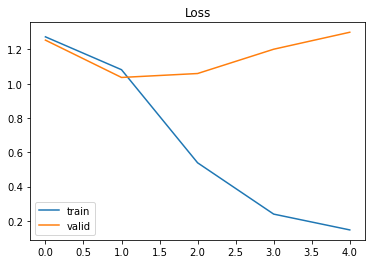

In [38]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

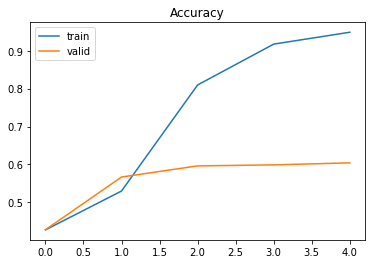

In [39]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();

              precision    recall  f1-score   support

           0       0.69      0.78      0.74       558
           1       0.69      0.58      0.63       357
           2       0.34      0.33      0.33       123
           3       0.61      0.59      0.60       382

    accuracy                           0.64      1420
   macro avg       0.58      0.57      0.57      1420
weighted avg       0.64      0.64      0.64      1420



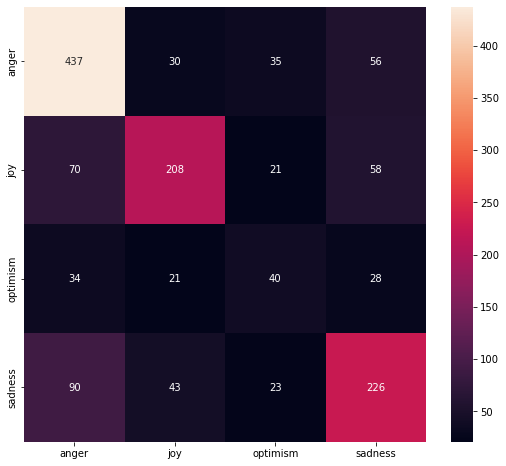

In [40]:
y_pred = np.argmax(model_5.predict(X_test), axis=-1)
y_true = list(df_test["label"])

print(classification_report(y_true, y_pred))

fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
            xticklabels=["anger", "joy", "optimism", "sadness"],
            yticklabels=["anger", "joy", "optimism", "sadness"], 
            ax=ax)
plt.show()